# Imports

## Import Packages

In [3]:
import pandas as pd
import numpy as np
from fontTools.subset import intersect
from pandas import read_csv
from scipy.stats import chi2_contingency, norm, chi2
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

## Import Functions

In [11]:
from src.K_Means_optimisation_GenePy import KM_opt, KM_opt_stabl, KM, KM_random, compute_ari_matrix, KM_RF, merge_phen_genepy, compute_clustering_metrics
from src.cluster_enrichment_analysis import analyze_cluster_deviations
from src.Plotting import plotk, plot_ari_heatmap, plot_clustering_metrics

## Import SPARC IBD CADD15 GenePy Matrix

In [12]:
#Import SPARC IBD CADD15 GenePy matrix
SPARC_IBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/IBD Plexus/GenePy/sparc_ibd_ccds_CADD15_merged_filt_mmscaled.matrix")

#Set samid as index
SPARC_IBD_CADD15_GenePy = SPARC_IBD_CADD15_GenePy.set_index("samid")

## Import Southampton IBD CADD15 GenePy Matrix

In [13]:
# Import Soton Local IBD CADD15 GenePy matrix
#dtype_dict = {"Gender": "object", "Age at diagnosis": "float64",
#              'Diagnosis': "object", "Stricturing": "object", "Fistulating": "object",
#              'Granuloma': "object", 'IBD Surgery': 'int64', 'IBD phenotype': 'object'}

SotonIBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Soton Local IBD/GenePy/jcmar24_IBD_CADD15_merged_filt_mmscaled.matrix"
                                       #,dtype=dtype_dict
                                       )

#Set samid as index
SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy.set_index("Samid")

#SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy[SotonIBD_CADD15_GenePy['Diagnosis'] != "NOT_IBD"]

## Import Gene Lists

In [14]:
NOD_sig_genes9 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes9.txt")
NOD_sig_genes43 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes43.txt")
JAK_STAT_sig_genes_30 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/JAK_STAT_sig_genes30.txt")
IL10_sig_genes_49 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes49.txt")
IL23_sig_genes_20 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL23_genes20.txt")
Th17_sig_genes_11 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/Th17_genes11.txt") #All of these genes are in the list of 20 IL-23 signalling genes
NADPH_genes_12 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes12.txt")
NADPH_genes_36 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes36.txt")

In [ ]:
NOD2_gene = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] == 'NOD2',:]
NOD_sig_genes9_noNOD2 = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] != 'NOD2',:]

### IBD Consensus Pathways

In [4]:
IBD_consensus_paths = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Progression Reviews/Confirmation Progression Review/Supp material/Consensus IBD pathway genes.txt")
IBD_union_genes = IBD_consensus_paths.loc[(IBD_consensus_paths['NOD signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-10 signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-23 signalling consensus 2'] == 1) |
(IBD_consensus_paths['Th17 differentiation consensus 2']) | (IBD_consensus_paths['JAK-STAT consensus 2'] == 1) | (IBD_consensus_paths['NADPH oxidases consensus 2'] == 1),:]
IBD_union_genes = IBD_union_genes.iloc[:,list(range(0,4)) + [11] + [13] + [15] +[17] + [19] + [21]]
IBD_union_genes.loc[IBD_union_genes['Gene name'] == 'NOXO1', 'Gene stable ID'] = "ENSG00000196408"

In [7]:
IBD_union_genes['GenePy gene'] = IBD_union_genes['Gene stable ID'] + "_" + IBD_union_genes['Gene name'] + "_CADD15_matrix"
IBD_union_genes_sparc = IBD_union_genes.loc[:,['Gene stable ID', 'Gene name', 'GenePy gene']]

In [10]:
IBD_union_genes_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IBD_union_genes.txt", index=False, sep='\t')

# SPARC IBD

## NOD2

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='SPARC')

In [ ]:
plotk(results_df, [18,37, 47])

In [ ]:
#k = 18
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD2_gene, 18)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
#Get list of patients with no NOD2 signal
SPARC_GenePy_0_NOD2_samid = km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 1]['Samid']
SPARC_GenePy_0_NOD2_samid

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_NOD2_18C_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

In [ ]:
results_df['IBD surgery final']['corr_p_values_chi2'] #.keys()

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10]['ENSG00000167207_NOD2_CADD15_matrix'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 3) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

## 9 NOD Signalling Genes

In [29]:
#Optimise k based on silhouette score and DBI
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='SPARC')

In [31]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.642724,0.626674,2827
1,3,0.304913,2.691593,1937
2,4,0.334981,2.172020,1856
3,5,0.348728,1.834343,1828
4,6,0.372934,1.605035,1783
5,7,0.346492,1.202347,1768
6,8,0.382008,0.980082,1552
7,9,0.427225,0.898065,1498
8,10,0.418584,0.946270,1498
9,11,0.441379,0.884471,1472


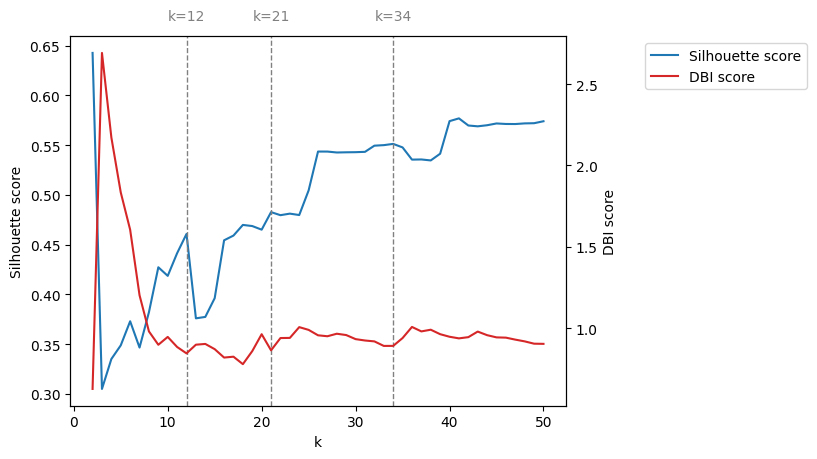

In [33]:
plotk(results_df, [12,21, 34])

In [ ]:
#Optimise k based on silhouette score, DBI, and ARI
metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, "SPARC", n_iter=100)

In [25]:
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", sep="\t", index=False)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", index_col=None)

In [27]:
metrics_df.index

RangeIndex(start=0, stop=49, step=1)

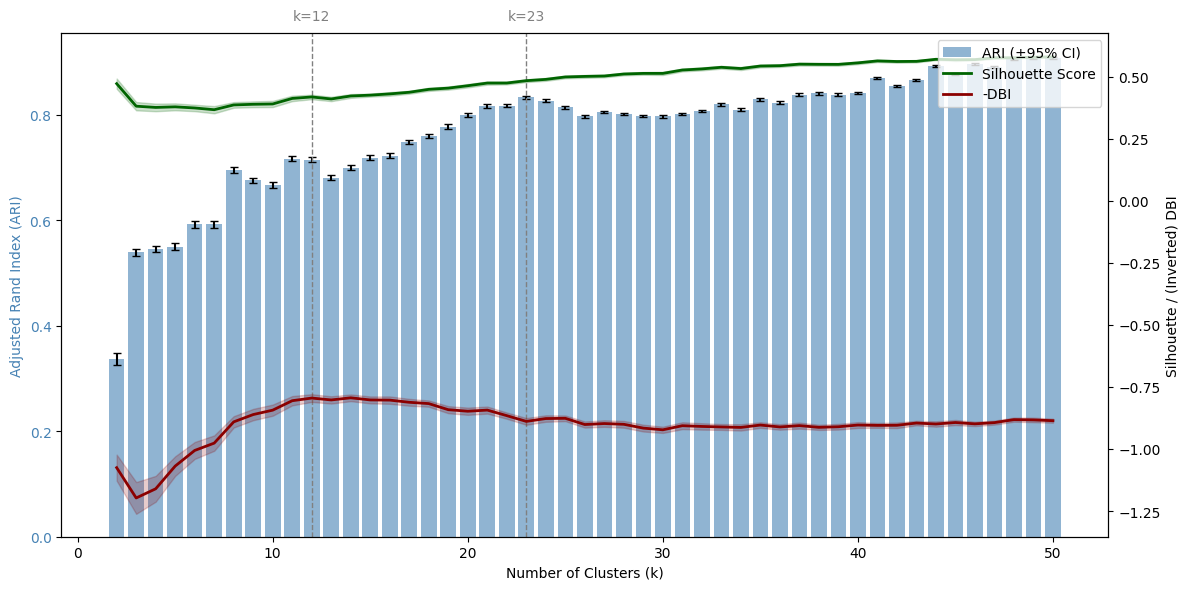

In [28]:
plot_clustering_metrics(metrics_df, vlines=[12, 23])

### K = 23

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 23)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_9F_23C_NOD_2_genepy.txt", sep='\t', index=False)


In [ ]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 17].sort_values("Importance", ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
#results_df['Diagnosis']['overall_p_value'] #.keys()
#type(results_df['Diagnosis']['overall_p_value'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 35

In [ ]:
#For k = 21, silhouette score is 0.5126 and the DBI score is 0.8283
#k = 15; silhouette score = 0.398559; DBI = 0.923939
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 35)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_9F_35C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
feat_imp_sparc = KM_RF(km_out, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp_sparc[feat_imp_sparc['Feature'] == "ENSG00000167207_NOD2_CADD15_matrix"].sort_values(by="Importance", ascending=False)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 17].sort_values(by="Importance", ascending=False)

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 1]['ENSG00000106100_NOD1_CADD15_matrix'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy_sparc[km_out_phen_GenePy_sparc['Cluster'] == 3]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy_sparc[(km_out_phen_GenePy_sparc['Cluster'] == 3) & (km_out_phen_GenePy_sparc['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

In [ ]:
#Check raw and multiple-test-corrected p-values
results_df['Diagnosis']['p_values_chi2']#.keys()

### K = 21

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
feat_imp[feat_imp['Cluster'] == 7].sort_values(by='Importance', ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Diagnosis']['corr_p_values_chi2']#.keys()

In [ ]:
#Cluster 14 - enriched for CD and depleted for UC
#193 CD/UC patients with NOD2 GenePy within 0.2607 to 0.4545, RIPK2 GenePy =< 0.1756 (192 have a score of 0) and NOD1 within 0 and 0.394107
SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.454504) &
                                             (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.394107)).astype(int)

# SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] <= 0.454504) &
#                                               (SotonIBD_CADD15_GenePy['ENSG00000104312.8_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100.11_NOD1'] <= 0.394107)).astype(int)

In [ ]:
#Cluster 19 is depleted for UC (n = 113)
#NOD2 (47.15%) -> 0.132311-0.406112
#RIPK2 (46.16%) -> 0.175602-0.490679
#NOD1 (2.1369%) -> <= 0.127193
SotonIBD_CADD15_GenePy['cluster 19'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311) &
                                               (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.406112) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679) &
                                              (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.127193)).astype(int)

In [ ]:
#Cluster 4 is depleted for UC
#NOD2 (96.76%) -> >= 0.732
SotonIBD_CADD15_GenePy['cluster 4'] = (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.732).astype(int)

In [ ]:
#Cluster 12 -> 357 patients with NOD2 0 and CHUK 0, RIPK2 0
SotonIBD_CADD15_GenePy['cluster 12'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000213341_CHUK'] == 0)
                                            & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] == 0)).astype(int)

In [ ]:
SotonIBD_CADD15_GenePy.loc[(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679),:].value_counts("ENSG00000104312_RIPK2")

## 43 NOD Signalling Genes

In [18]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [20]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.322185,3.627469,2549
1,3,0.174950,2.355673,2333
2,4,0.178354,2.774589,2170
3,5,0.175838,2.716224,2130
4,6,0.102756,3.207732,1639
5,7,0.092507,2.964704,1585
6,8,0.171568,2.739102,1809
7,9,0.176391,2.258880,1877
8,10,0.173716,2.457492,1755
9,11,0.163377,2.324370,1710


In [16]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.153476,0.318963,0.008889,0.275374,0.095685,0.019082,2.558638,0.810185,0.161568
1,3,0.291612,0.310490,0.008653,0.192222,0.083553,0.016662,2.630545,0.547209,0.109125
2,4,0.404722,0.251037,0.006996,0.178892,0.070204,0.014000,2.591557,0.418883,0.083534
3,5,0.444131,0.208457,0.005809,0.155733,0.047309,0.009434,2.452047,0.377515,0.075285
4,6,0.438202,0.179080,0.004990,0.142385,0.046305,0.009234,2.459744,0.264602,0.052767
5,7,0.410727,0.161356,0.004497,0.136179,0.052451,0.010460,2.419943,0.324744,0.064761
6,8,0.434477,0.139918,0.003899,0.121587,0.041725,0.008321,2.378750,0.240772,0.048015
7,9,0.418439,0.144343,0.004022,0.117115,0.040069,0.007991,2.275997,0.221443,0.044161
8,10,0.412417,0.136053,0.003791,0.111529,0.037501,0.007478,2.254066,0.195828,0.039052
9,11,0.401589,0.136678,0.003809,0.114263,0.042173,0.008410,2.173093,0.197700,0.039426


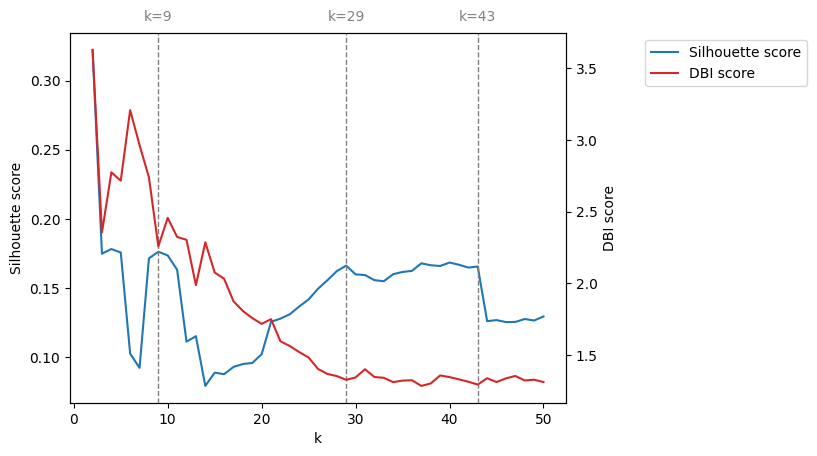

In [24]:
plotk(results_df, [9, 29, 43])

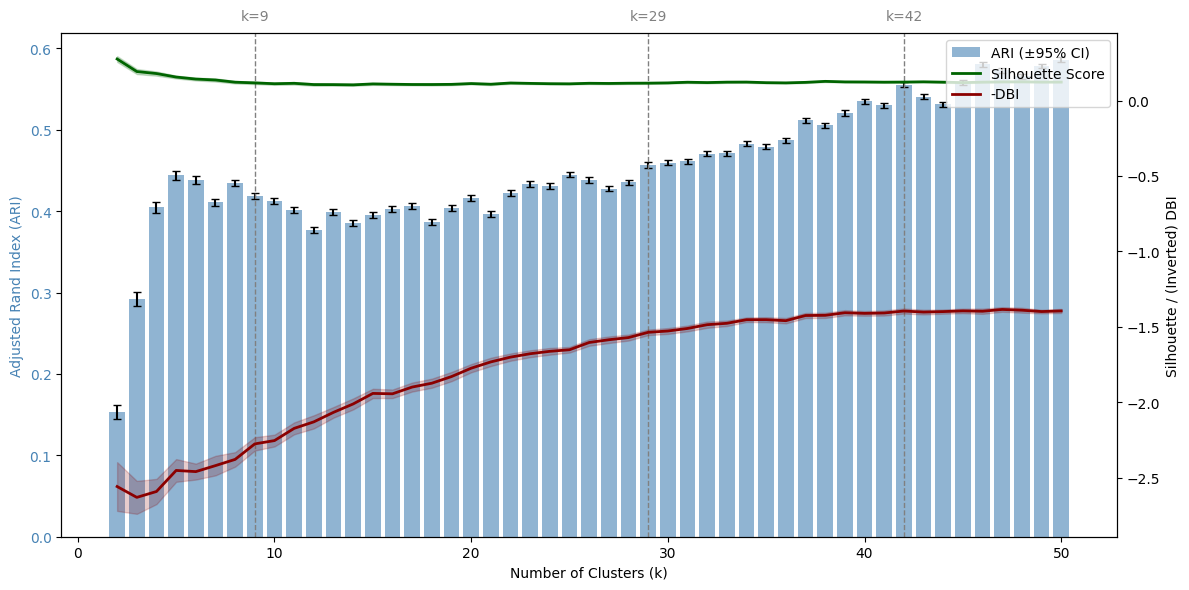

In [26]:
plot_clustering_metrics(metrics_df, vlines=[9, 29, 42])

In [ ]:
# k = 16
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 16)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
#km_out.value_counts()

In [ ]:
feat_imp = KM_RF(km_out_sparc, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Diagnosis']['corr_p_values_chi2']

In [ ]:
results_df['Crohn s disease phenotype']['corr_p_values_chi2']

In [ ]:
results_df['IBD surgery final']['corr_p_values_chi2']

In [ ]:
#Cluster 1
#NOD2 70.22% -> 0.1323 - 0.3652
#SUGT1 3.96% -> <= 0.2013
#ERBIN 2.67% ->  <= 0.3058
#MAPK12 2.09% -> <= 0.2843
#NOD1 1.75% -> <= 0.2768
#RELA 1.69% -> 0
#BIRC3 1.69% -> 0
#NLRP1 1.43% -> <= 0.2021
#CASP8 1.32% -> <= 0.09
SotonIBD_CADD15_GenePy['Cluster 1'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311468176971) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.365205488832726)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.201280690665366) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.375835188227294)&
                                       (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.276787154268017) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)).astype(int)

In [ ]:
#Cluster 5
#NOD2 46.21% -> 0
#SUGT1 13.83% -> <= 0.007
#ERBIN 5.16% -> <= 0.3254
#MAPK12 4.22% -> <= 0.2843
#NOD1 3.65% -> <= 0.3178
#RELA 3.59% -> 0
#NRLP1 3.15% -> <= 0.2021
#CARD9 2.84% -> 0
#BIRC3 2.31% -> 0
#TAB1 2.12% -> 0
#CARD8 1.77% -> 0
#NLRP7 1.31% -> 0
SotonIBD_CADD15_GenePy['Cluster 5'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.0070120773143289)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.325406754325555)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.317840326123237) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)&(SotonIBD_CADD15_GenePy['ENSG00000187796_CARD9'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0)& (SotonIBD_CADD15_GenePy['ENSG00000100324_TAB1'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000105483_CARD8'] == 0)
                                       ).astype(int)

In [ ]:
#Cluster 13
#NOD2 76.41% -> >= 0.3585
#ERBIN 2.08% -> <= 0.5793
#NOD1 1.88% -> <= 0.5118
#CASP9 1.62% -> <= 0.6922
#NLRP12 1.42% <= 0.4622
#MAPK12 1.37% -> <= 0.44
#RELA 1.17% -> <= 0.4136
#CARD6 1.07% -> <= 0.4563
SotonIBD_CADD15_GenePy['Cluster 13'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.358468103620945) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.579367065203214) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.511821245992663) & (SotonIBD_CADD15_GenePy['ENSG00000132906_CASP9'] <= 0.692219162925112)
                                        & (SotonIBD_CADD15_GenePy['ENSG00000142405_NLRP12'] <= 0.462179899117249)&
                                        (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.442011527819315) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] <= 0.41358255389904) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000132357_CARD6'] <= 0.456358576821125)
                                        ).astype(int)

In [ ]:
cont_table = pd.crosstab(SotonIBD_CADD15_GenePy['Cluster 1'], SotonIBD_CADD15_GenePy['IBD Surgery'])
#Remove IBDU
#cont_table = cont_table.iloc[:,[0,3]]
#chi square
chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
p_value

In [ ]:
# k = 38
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 38)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Crohn s disease phenotype']['overall_p_value']

In [ ]:
results_df['Diagnosis'].keys()

## Other Pathways

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NADPH_genes_36, 50, cohort_name='SPARC')

In [ ]:
results_df

In [ ]:
plotk(results_df)

In [ ]:
#k = 32
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NADPH_genes_36, 24)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)


In [ ]:
#km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_30F_32C_JAK_STAT_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

## 34 Consensus IBD Genes

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 50, cohort_name='SPARC')

In [ ]:
plotk(results_df, [28, 35, 40])

In [ ]:
# k = 40
km_out, X = KM(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 40)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 17].value_counts('Crohn s disease phenotype', normalize=True)

In [ ]:
km_out_phen_GenePy.value_counts('Crohn s disease phenotype', normalize=True)

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
#len(feat_imp[feat_imp['Importance'] >= 0.1]['Feature'].unique())
feat_imp[feat_imp['Cluster'] == 22]

In [ ]:
results_chi2 = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_chi2['Diagnosis']['p_values_chi2']

In [ ]:
results_chi2['Diagnosis']['residuals']

In [ ]:
results_chi2['Crohn s disease phenotype']['p_values_chi2']

In [ ]:
results_chi2['Crohn s disease phenotype']['residuals']

In [ ]:
results_chi2['IBD surgery final']['p_values_chi2']

In [ ]:
results_chi2['Diagnosis'].keys()

# Southampton IBD

## NOD2

In [ ]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='Soton')

In [ ]:
results_df

In [ ]:
plotk(results_df, [13, 20, 38])

In [ ]:
#k = 13
km_out, X = KM(SotonIBD_CADD15_GenePy, NOD2_gene, 13, "Soton")
km_out_phen_GenePy = merge_phen_genepy(km_out, SotonIBD_CADD15_GenePy, X, "Soton")

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/Soton_KMeans_NOD2_13C_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD phenotype', 'IBD Surgery', 'Granuloma'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['IBD phenotype']['overall_p_value'])
print(results_df['IBD Surgery']['overall_p_value'])
print(results_df['Granuloma']['overall_p_value'])

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] ==5 ]['ENSG00000167207.15_NOD2'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 5]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 12) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


## 9 NOD Signalling Genes

In [10]:
#results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='Soton')
metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, "Soton", n_iter=100)

In [17]:
metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig8_clustering_metrics.txt", sep="\t", index=False) #No IKBKG GenePy

In [14]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.311966,0.424856,0.011840,0.493945,0.118800,0.023691,1.073603,0.391217,0.078017
1,3,0.558969,0.280720,0.007823,0.444341,0.069026,0.013765,1.069780,0.279243,0.055687
2,4,0.576375,0.269632,0.007514,0.436055,0.090221,0.017992,1.000535,0.263186,0.052485
3,5,0.602198,0.247743,0.006904,0.426758,0.087902,0.017530,0.950822,0.210189,0.041916
4,6,0.609700,0.235305,0.006557,0.418156,0.086052,0.017161,0.898692,0.160665,0.032040
5,7,0.601560,0.212089,0.005910,0.406852,0.077650,0.015485,0.879487,0.142248,0.028367
6,8,0.667450,0.218653,0.006093,0.419245,0.055829,0.011133,0.830753,0.111325,0.022201
7,9,0.724649,0.211719,0.005900,0.421446,0.040592,0.008095,0.811920,0.080354,0.016024
8,10,0.780982,0.192196,0.005356,0.428920,0.036066,0.007192,0.789915,0.081626,0.016278
9,11,0.722705,0.205741,0.005733,0.432840,0.037975,0.007573,0.767367,0.075599,0.015076


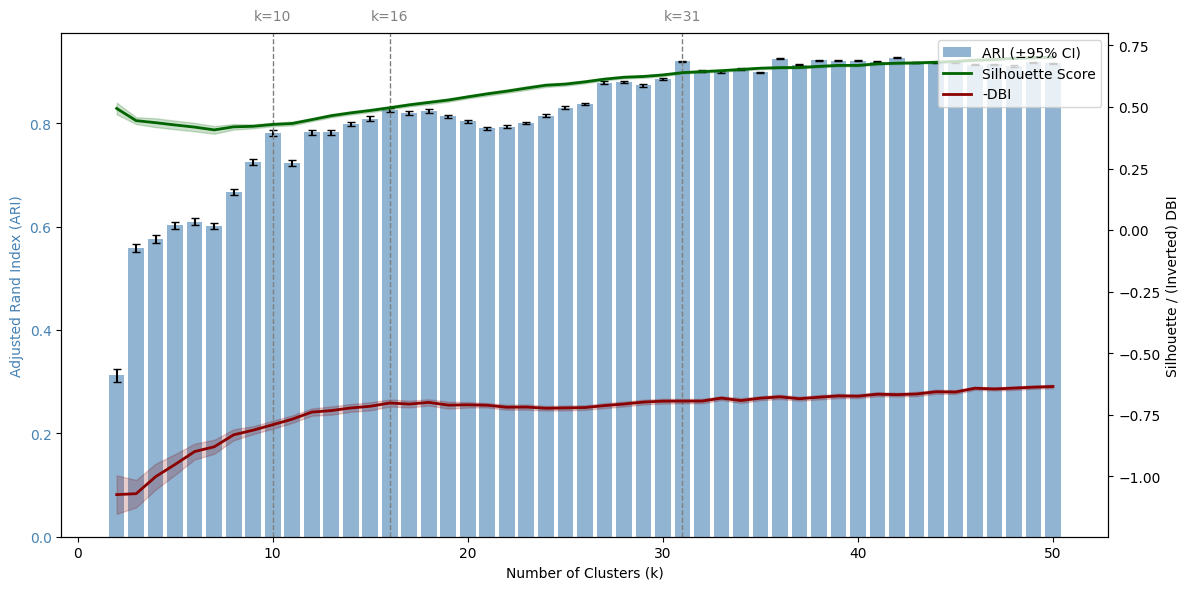

In [15]:
#plotk(results_df,[21, 25, 32])
plot_clustering_metrics(metrics_df, vlines=[10, 16, 31])

### K = 16

In [7]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 16, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_16C_NOD_2_genepy.txt", sep='\t', index=False)

In [8]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [9]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])

In [12]:
results_df['IBD.Surgery']['overall_p_value']

np.float64(0.289205714355346)

### K = 32

In [ ]:
#k = 32
km_out, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 32, "Soton")
km_out_phen_GenePy = merge_phen_genepy(km_out, SotonIBD_CADD15_GenePy, X, "Soton")
#km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/Soton_KMeans_9F_32C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_phen_GenePy

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD phenotype', 'IBD Surgery', 'Granuloma'])

In [ ]:
results_df['Diagnosis']['overall_p_value']

In [ ]:
results_df['IBD phenotype']['residuals']#.keys()

In [ ]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp[feat_imp['Feature'] == "ENSG00000167207.15_NOD2"].sort_values(by="Importance", ascending=False)

In [ ]:
feat_imp[feat_imp['Cluster'] == 17].sort_values(by="Importance", ascending=False)

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 9]['ENSG00000187796.16_CARD9'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 20]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 7) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

In [ ]:
#Check raw and multiple-test-corrected p-values
results_df['Granuloma']['overall_p_value']#.keys()

## 43 NOD Signalling Genes

In [27]:
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt", sep="\t", index=False)

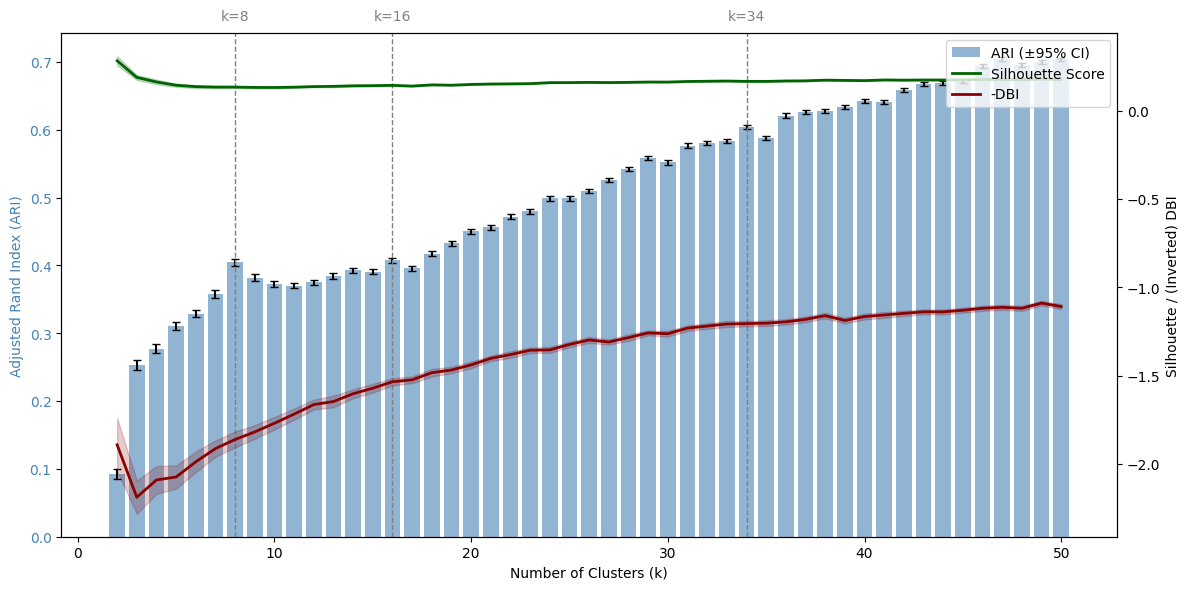

In [33]:
plot_clustering_metrics(metrics_df, vlines=[8, 16, 34])

### K = 16

In [34]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 16, "Soton") #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_16C_NOD_2_genepy.txt", sep='\t', index=False)

In [45]:
outersect = set(NOD_sig_genes43.iloc[:, 2].str.split('_').str[0]) - set(SotonIBD_CADD15_GenePy.columns.str.split('_').str[0])
outersect
#pd.intersect(SotonIBD_CADD15_GenePy.columns.str.split('_').str[0], NOD_sig_genes43.iloc[:, 2].str.split('_').str[0])

{'ENSG00000150782', 'ENSG00000167634', 'ENSG00000249437', 'ENSG00000269335'}

In [44]:
SotonIBD_CADD15_GenePy.columns.str.split('_').str[0]

Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000000938', 'ENSG00000000971',
       'ENSG00000001036', 'ENSG00000001084', 'ENSG00000001167',
       'ENSG00000001460',
       ...
       'ENSG00000293553', 'ENSG00000293555', 'Gender', 'Age.at.diagnosis',
       'Diagnosis', 'Stricturing', 'Fistulating', 'Granuloma', 'IBD.Surgery',
       'IBD.phenotype'],
      dtype='object', length=20330)